# AIPI 590 - XAI | Adversarial Patches

Description:

Christian Moreira

[![GitHub Repo](https://img.shields.io/badge/GitHub-Repo-black.svg?logo=github&style=for-the-badge)](https://github.com/U1186204/Adversarial-Patches/tree/main)

[![Open In Colab](https://img.shields.io/badge/Open%20In-Colab-F9AB00.svg?logo=googlecolab&style=for-the-badge)](https://colab.research.google.com/github/U1186204/Adversarial-Patches/blob/main/main.ipynb)



### Importing Libraries

In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg
from PIL import Image # For saving the final .png file

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torchvision.transforms.functional as TF # For rotations/scaling

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default.
    !pip install --quiet pytorch_lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# --- Paths (Corrected for Colab) ---
DATASET_PATH = "data"
CHECKPOINT_PATH = "saved_models/tutorial10"
CUSTOM_PATCH_PATH = os.path.join(CHECKPOINT_PATH, "custom")
os.makedirs(CUSTOM_PATCH_PATH, exist_ok=True)

# --- Reproducibility ---
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Device (Will be CUDA thanks to Step 1) ---
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)
print(f"Custom patch will be saved to: {CUSTOM_PATCH_PATH}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0
Custom patch will be saved to: saved_models/tutorial10/custom


In [2]:
import urllib.request
from urllib.error import HTTPError
import zipfile

# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]

# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Corrected unzipping line
                zip_ref.extractall(dir_name)

In [3]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [4]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Did you run Cell 2? Is 'TinyImageNet' in your 'data' folder?"
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)

# num_workers=0 is stabler in Colab/Windows
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=0)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [5]:
# ---!!! NEW FUNNY OBJECT: 'llama' !!!---
target_class_name = 'llama'
target_class_idx = 355

assert target_class_name in label_names, "Target class name not in label list!"

print(f"Target Acquired! We will make the model see: **{target_class_name}** (Index: {target_class_idx})")

# Let's also define our patch size
PATCH_SIZE = 64

Target Acquired! We will make the model see: **llama** (Index: 355)


In [6]:
# (This cell is identical to the professor's)

def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

# Grab a batch of images for later testing
exmp_batch, label_batch = next(iter(data_loader))

In [7]:
# --- Define normalization constants on the correct device ---
TENSOR_MEANS = torch.FloatTensor(NORM_MEAN).to(device)[:,None,None]
TENSOR_STD = torch.FloatTensor(NORM_STD).to(device)[:,None,None]

# This is the professor's exact patch_forward function.
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch_0_1 = (torch.tanh(patch) + 1) / 2
    return (patch_0_1 - TENSOR_MEANS) / TENSOR_STD

# This is the robust place_patch function that adds rotation and scaling.
def place_patch(img, patch):
    # Get the patch image (this will be on the device, since patch is)
    patch_img = patch_forward(patch)

    # Get patch dimensions
    patch_height = patch.shape[1]
    patch_width = patch.shape[2]

    for i in range(img.shape[0]):
        # --- Start Transformations ---
        # Create a mask
        mask = torch.ones_like(patch_img)

        # 1. Random Rotation (This is the "creative component")
        angle = float(torch.empty(1).uniform_(-20, 20)) # Stable range
        patch_rotated = TF.rotate(patch_img, angle, fill=0)
        mask_rotated = TF.rotate(mask, angle, fill=0)

        # 2. Random Scaling (This is the "creative component")
        scale_factor = float(torch.empty(1).uniform_(0.75, 1.25)) # Stable range
        new_height = int(patch_height * scale_factor)
        new_width = int(patch_width * scale_factor)

        # Ensure size is at least 1 pixel
        if new_height < 1: new_height = 1
        if new_width < 1: new_width = 1

        patch_transformed = TF.resize(patch_rotated, [new_height, new_width], antialias=True)
        mask_transformed = TF.resize(mask_rotated, [new_height, new_width], antialias=True)
        # Binarize mask again after resize interpolation
        mask_transformed = (mask_transformed > 0.5).float()
        # --- End Transformations ---

        # 3. Random Location
        if new_height >= img.shape[2]: h_offset = 0
        else: h_offset = np.random.randint(0, img.shape[2] - new_height - 1)

        if new_width >= img.shape[3]: w_offset = 0
        else: w_offset = np.random.randint(0, img.shape[3] - new_width - 1)

        # Apply the patch using the mask
        target_area = img[i, :, h_offset : h_offset + new_height, w_offset : w_offset + new_width]

        img[i, :, h_offset : h_offset + new_height, w_offset : w_offset + new_width] = \
            (1.0 - mask_transformed) * target_area + mask_transformed * patch_transformed

    return img

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image
            for _ in range(4):
                # Bug fix: Move tensors to device BEFORE patching
                img_labels = img_labels.to(device)
                img_device = img.clone().to(device)
                patch_img = place_patch(img_device, patch) # Now both are on device

                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()

    if counter.item() == 0:
        return torch.tensor(0.0), torch.tensor(0.0)

    acc = tp.float() / counter
    top5 = tp_5.float() / counter
    return acc, top5

In [8]:
# This is the professor's exact function, just with num_workers=0,
# the "leaf tensor" fix, and the "img.to(device)" fix.

def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Split dataset
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=0)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=0)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)

    # Start from a blank slate (torch.zeros)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1], device=device), requires_grad=True)

    # Use the professor's exact optimizer settings
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    print(f"Starting attack. Tuning patch to target class '{label_names[target_class]}'")

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            # Bug fix: Move image to device FIRST
            img = img.to(device)
            img = place_patch(img, patch) # Now patching happens on GPU

            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():4.2f}")

        # Get the loss from the last batch
        avg_train_loss = loss.mean().item()
        print(f"Epoch {epoch+1} finished. Last Batch Loss: {avg_train_loss:4.2f}")

    # Final validation
    print("Training finished. Running final validation...")
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [9]:
EPOCHS_TO_TRAIN = 15

patch_tensor, val_results = patch_attack(
    pretrained_model,
    target_class=target_class_idx,
    patch_size=PATCH_SIZE,
    num_epochs=EPOCHS_TO_TRAIN
)

print("\n---!!! TRAINING COMPLETE !!!---")
print(f"Validation results for '{target_class_name}':")
print(f"  Top-1 Fooling Accuracy: {val_results['acc']*100.0:4.2f}%")
print(f"  Top-5 Fooling Accuracy: {val_results['top5']*100.0:4.2f}%")

patch_filename = os.path.join(CUSTOM_PATCH_PATH, f"{target_class_name}_patch.pt")
torch.save(patch_tensor, patch_filename)
print(f"Patch tensor saved to {patch_filename}")

Starting attack. Tuning patch to target class 'llama'


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 finished. Last Batch Loss: 10.76


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 finished. Last Batch Loss: 5.52


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 3 finished. Last Batch Loss: 2.60


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 4 finished. Last Batch Loss: 3.49


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 5 finished. Last Batch Loss: 2.64


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 6 finished. Last Batch Loss: 1.28


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 7 finished. Last Batch Loss: 1.85


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 8 finished. Last Batch Loss: 2.59


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 9 finished. Last Batch Loss: 1.41


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 10 finished. Last Batch Loss: 1.12


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 11 finished. Last Batch Loss: 1.33


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 12 finished. Last Batch Loss: 1.76


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 13 finished. Last Batch Loss: 0.87


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 14 finished. Last Batch Loss: 2.15


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 15 finished. Last Batch Loss: 1.44
Training finished. Running final validation...


Validating...:   0%|          | 0/16 [00:00<?, ?it/s]


---!!! TRAINING COMPLETE !!!---
Validation results for 'llama':
  Top-1 Fooling Accuracy: 75.25%
  Top-5 Fooling Accuracy: 92.35%
Patch tensor saved to saved_models/tutorial10/custom/llama_patch.pt


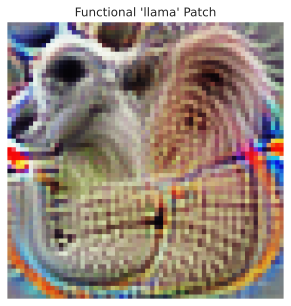

******************************************************************
SUCCESS! Your final patch image is saved to:
saved_models/tutorial10/custom/FINAL_llama_patch.png

This is the image you should print for your physical patch!
******************************************************************


In [10]:
def visualize_patch(patch_tensor):
    patch_0_1 = (torch.tanh(patch_tensor.cpu()) + 1) / 2
    patch_np = patch_0_1.permute(1, 2, 0).numpy()
    patch_np = np.clip(patch_np, a_min=0.0, a_max=1.0)
    return patch_np

adversarial_patch_np = visualize_patch(patch_tensor)

plt.figure(figsize=(5, 5))
plt.imshow(adversarial_patch_np)
plt.title(f"Functional '{target_class_name}' Patch")
plt.axis('off')
plt.show()


final_patch_img = Image.fromarray((adversarial_patch_np * 255).astype(np.uint8))
png_filename = os.path.join(CUSTOM_PATCH_PATH, f"FINAL_{target_class_name}_patch.png")
final_patch_img.save(png_filename)




--- Adversarial Patch (Target: 'llama') ---


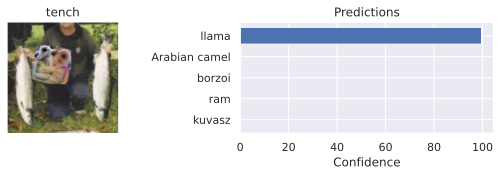

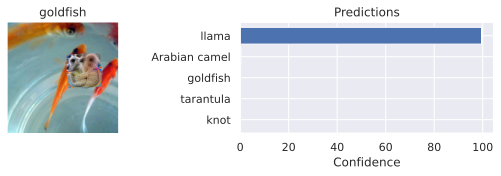

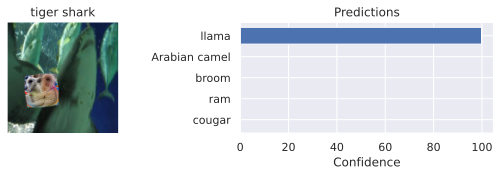

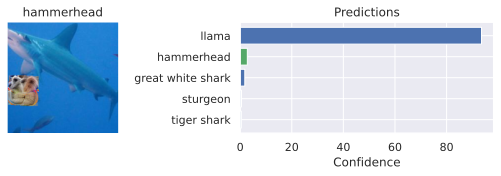

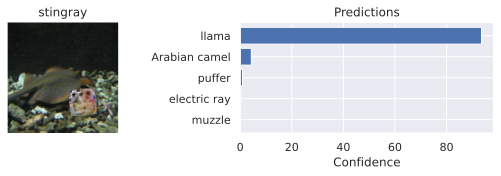

In [14]:
def perform_patch_attack_test(patch_tensor, title):
    print(f"\n--- {title} ---")

    patch_batch = exmp_batch.clone().to(device)
    patch_tensor_device = patch_tensor.to(device)
    patch_batch = place_patch(patch_batch, patch_tensor_device)

    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch) # Already on device

    for i in range(2, 36, 7):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

perform_patch_attack_test(patch_tensor, f"Adversarial Patch (Target: '{target_class_name}')")